In [2]:
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib.image import imread
import cv2
import random
from os import listdir
from sklearn.preprocessing import  LabelBinarizer, LabelEncoder
from keras.preprocessing import image
from keras.preprocessing.image import img_to_array, array_to_img
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.optimizers import Adam
from PIL import Image
from keras.models import Sequential
from tensorflow.keras.layers import BatchNormalization
from keras.layers import Conv2D, MaxPooling2D, Activation, Flatten, Dropout, Dense, LeakyReLU
from sklearn.model_selection import train_test_split
from keras.utils import np_utils
from sklearn.metrics import classification_report


The melanoma dataset comes from the "kaggle" site.
Melanoma Skin Cancer Dataset contains 10000 images. Melanoma skin cancer is deadly cancer, early detection and cure can save many lives.

Size : 300x300 pixels

Color : RGB

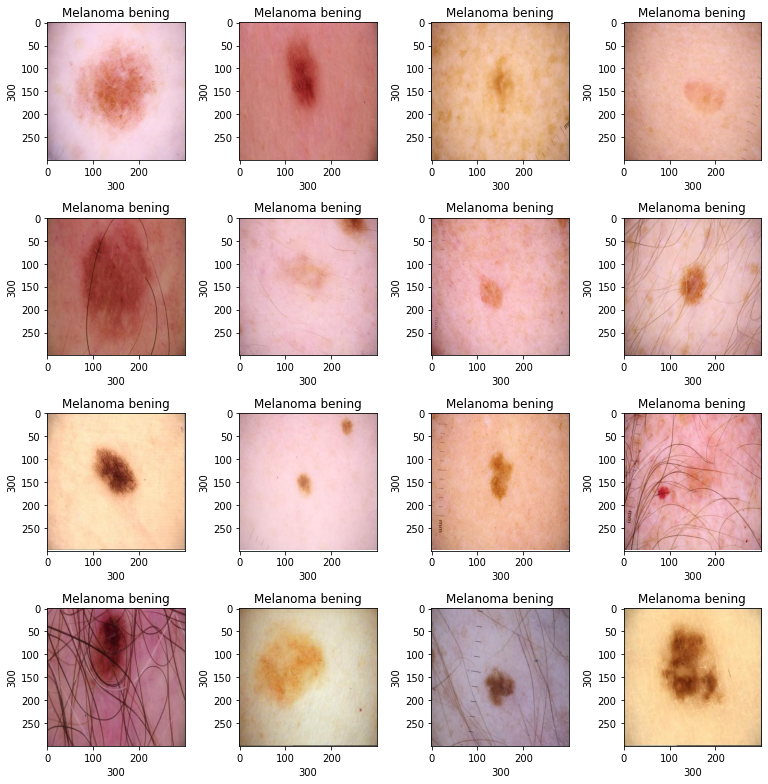

In [3]:
# Plotting 16 images to check dataset
plt.figure(figsize=(11,11))
path ="melanoma_cancer_dataset/benign"
for i in range(1,17):
    plt.subplot(4,4,i)
    plt.tight_layout()
    rand_img = imread(path +'/'+ random.choice(sorted(listdir(path))))
    plt.imshow(rand_img)
    plt.title('Melanoma bening')
    plt.xlabel(rand_img.shape[1], fontsize = 10)
    plt.ylabel(rand_img.shape[0], fontsize = 10)

# **Load and prepare data**

We go through all the folders and all the images. 
We resize the images with "img_size" variable and convert images to array.
Finally we create a list of images and a list of labels.

In [4]:
dir = "melanoma_cancer_dataset/"
root_dir = os.listdir(dir)
image_list = []
label_list = []

img_size = 150

# Load the data and store in a list
for directory in root_dir:
    for file in os.listdir(os.path.join(dir,directory)):
        image_path = os.path.join(dir,directory,file)
        image = Image.open(image_path)
        image = image.resize((img_size,img_size))
        image = img_to_array(image)
        image_list.append(image)
        label_list.append(directory)

In [5]:
# Print the number of labels
label_counts = pd.DataFrame(label_list).value_counts()
label_counts

benign       5500
malignant    5105
dtype: int64

In [6]:
# Print size images (10605 images 150x150 pixels with rgb channels)
np.array(image_list).shape

(10605, 150, 150, 3)

In [7]:
# Checking y data shape
label_list = np.array(label_list)
label_list.shape

(10605,)

We separate the data into two parts : 80% training and 20% test.

In [8]:
x_train, x_test, y_train, y_test = train_test_split(image_list, label_list, test_size=0.2)

# **Normalize data**
We change the data type to float16 and divide the values ​​by 255 to get values ​​between 0 and 1 to improve the speed of the model.

Then we align the input data sizes to make them compatible with our model

In [9]:
x_train = np.array(x_train, dtype=np.float16) / 255.0
x_test = np.array(x_test, dtype=np.float16) / 255.0
x_train = x_train.reshape( -1, img_size,img_size,3)
x_test = x_test.reshape( -1, img_size,img_size,3)
x_train.shape, x_test.shape

((8484, 150, 150, 3), (2121, 150, 150, 3))

Now we normalize the labels in 0 and 1 in a vector.

0 = benign

1 = malignant

In [10]:
y_test = np.array([[1,0] if l=='benign' else [0,1] for l in y_test])
y_train = np.array([[1,0] if l=='benign' else [0,1] for l in y_train])

print(f'Size y_train : {y_train.shape}')
print(f'Size y_test : {y_test.shape}')
print(y_train)

Size y_train : (8484, 2)
Size y_test : (2121, 2)
[[1 0]
 [0 1]
 [0 1]
 ...
 [0 1]
 [1 0]
 [0 1]]


# **Create first neural network model**

We create a sequential model using convolutional layers.


A convolutional layer use filter that scan the input and perform convolutional operations.

The pooling layer consists in bringing out specific characteristics on an image while reducing its size, which facilitates calculations and optimizes the speed of the model.

A Dense layer is a fully connected layer that is used to connect the output of the convolutional layer to the output of the neural network.

**We use 3 convolution layers :**
 - 32 filters of size 3x3
 - 64 filters of size 3x3
 - 128 filters of size 3x3

**We add 3 max-pooling layers of size 2x2**

**Output with Dense layer**
 - Flatten layer for to arrange the data for next layer
 - Dense layer with 128 neurons and activate by ReLU
 - Dense layer with 2 neurons and activate by softmax for to get the probability of the class

In [11]:
model = Sequential()
model.add(Conv2D(32, kernel_size=(3, 3),activation='linear',input_shape=(img_size,img_size,3),padding='same'))
model.add(LeakyReLU(alpha=0.1))
model.add(MaxPooling2D((2, 2),padding='same'))
model.add(Conv2D(64, (3, 3), activation='linear',padding='same'))
model.add(LeakyReLU(alpha=0.1))
model.add(MaxPooling2D(pool_size=(2, 2),padding='same'))
model.add(Conv2D(128, (3, 3), activation='linear',padding='same'))
model.add(LeakyReLU(alpha=0.1))                  
model.add(MaxPooling2D(pool_size=(2, 2),padding='same'))
model.add(Flatten())
model.add(Dense(128, activation='relu'))
model.add(LeakyReLU(alpha=0.1))        
model.add(Dense(2, activation='softmax'))

Compile the model with Adam optimizer and binary crossentropy loss.

We print the model summary.

In [11]:
model.compile(loss=keras.losses.categorical_crossentropy, optimizer=keras.optimizers.Adam(),metrics=['acc'])
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 150, 150, 32)      896       
                                                                 
 leaky_re_lu (LeakyReLU)     (None, 150, 150, 32)      0         
                                                                 
 max_pooling2d (MaxPooling2D  (None, 75, 75, 32)       0         
 )                                                               
                                                                 
 conv2d_1 (Conv2D)           (None, 75, 75, 64)        18496     
                                                                 
 leaky_re_lu_1 (LeakyReLU)   (None, 75, 75, 64)        0         
                                                                 
 max_pooling2d_1 (MaxPooling  (None, 38, 38, 64)       0         
 2D)                                                    

# **Train the model**

In [12]:
# Epoch is the number of times data is passed through our neural network
epochs = 20
# Batch size is the number of images we are passing through the network at a time.
batch_size = 64

validation_split = 0.1

We train the model with the training data that we split.

80% of the data is used for training and 20% for validation.

In [13]:
history = model.fit(x_train, y_train, epochs=epochs, batch_size = batch_size, validation_split=validation_split)

Epoch 1/20
120/120 [==============================] - 10s 46ms/step - loss: 0.4737 - acc: 0.7793 - val_loss: 0.3004 - val_acc: 0.8645
Epoch 2/20
120/120 [==============================] - 5s 40ms/step - loss: 0.2938 - acc: 0.8785 - val_loss: 0.2812 - val_acc: 0.8693
Epoch 3/20
120/120 [==============================] - 5s 40ms/step - loss: 0.2596 - acc: 0.8901 - val_loss: 0.2760 - val_acc: 0.8869
Epoch 4/20
120/120 [==============================] - 5s 40ms/step - loss: 0.2518 - acc: 0.8952 - val_loss: 0.2477 - val_acc: 0.8963
Epoch 5/20
120/120 [==============================] - 5s 40ms/step - loss: 0.2234 - acc: 0.9096 - val_loss: 0.2432 - val_acc: 0.9069
Epoch 6/20
120/120 [==============================] - 5s 40ms/step - loss: 0.2106 - acc: 0.9166 - val_loss: 0.2389 - val_acc: 0.9058
Epoch 7/20
120/120 [==============================] - 5s 40ms/step - loss: 0.1963 - acc: 0.9219 - val_loss: 0.2341 - val_acc: 0.9152
Epoch 8/20
120/120 [==============================] - 5s 40ms/step -

Save model and weights.

In [14]:
model.save("svg/nn_0.h5")

# **Evaluation of the model**



In [15]:
test_eval = model.evaluate(x_test, y_test)
print('Loss:', test_eval[0])
print('Accuracy:', test_eval[1])

67/67 [==============================] - 1s 10ms/step - loss: 0.3069 - acc: 0.9099
Loss: 0.30692172050476074
Accuracy: 0.9099481105804443


Accuracy is really good.

In [16]:
accuracy = history.history['acc']
val_accuracy = history.history['val_acc']
loss = history.history['loss']
val_loss = history.history['val_loss']
epochs = range(len(accuracy))

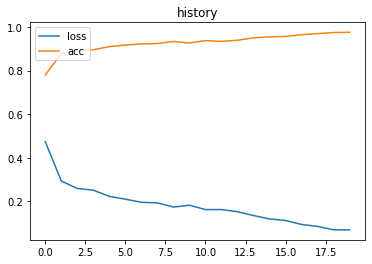

In [17]:
plt.plot(loss, label="loss")
plt.plot(accuracy, label="acc")
plt.legend(loc='upper left')
plt.title("history")
plt.show()

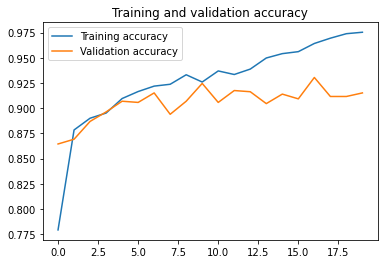

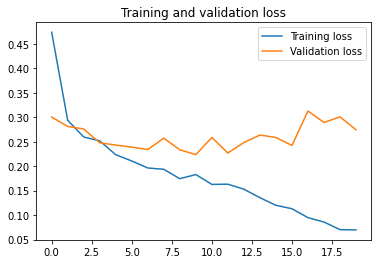

In [18]:
# print the classification report

plt.plot(epochs, accuracy, label='Training accuracy')
plt.plot(epochs, val_accuracy, label='Validation accuracy')
plt.title('Training and validation accuracy')
plt.legend()
plt.figure()
plt.plot(epochs, loss, label='Training loss')
plt.plot(epochs, val_loss, label='Validation loss')
plt.title('Training and validation loss')
plt.legend()
plt.show()

With the graph, we can see that from epoch 11, the model begins to be overfitting.
We will add dropout to solve the it.

In [19]:
# Epoch is the number of times data is passed through our neural network
epochs = 20
# Batch size is the number of images we are passing through the network at a time.
batch_size = 64
validation_split = 0.1

In [20]:
model = Sequential()
model.add(Conv2D(32, kernel_size=(3, 3),activation='linear',input_shape=(img_size,img_size,3),padding='same'))
model.add(LeakyReLU(alpha=0.1))
model.add(MaxPooling2D((2, 2),padding='same'))
model.add(Dropout(0.30))
model.add(Conv2D(64, (3, 3), activation='linear',padding='same'))
model.add(LeakyReLU(alpha=0.1))
model.add(MaxPooling2D(pool_size=(2, 2),padding='same'))
model.add(Dropout(0.30))
model.add(Conv2D(128, (3, 3), activation='linear',padding='same'))
model.add(LeakyReLU(alpha=0.1))                  
model.add(MaxPooling2D(pool_size=(2, 2),padding='same'))
model.add(Flatten())
model.add(Dropout(0.40))
model.add(Dense(128, activation='relu'))
model.add(LeakyReLU(alpha=0.1))    
model.add(Dropout(0.8))
model.add(Dense(2, activation='softmax'))

In [21]:
model.compile(loss=keras.losses.categorical_crossentropy, optimizer=keras.optimizers.Adam(),metrics=['acc'])
model.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_3 (Conv2D)           (None, 150, 150, 32)      896       
                                                                 
 leaky_re_lu_4 (LeakyReLU)   (None, 150, 150, 32)      0         
                                                                 
 max_pooling2d_3 (MaxPooling  (None, 75, 75, 32)       0         
 2D)                                                             
                                                                 
 dropout (Dropout)           (None, 75, 75, 32)        0         
                                                                 
 conv2d_4 (Conv2D)           (None, 75, 75, 64)        18496     
                                                                 
 leaky_re_lu_5 (LeakyReLU)   (None, 75, 75, 64)        0         
                                                      

In [22]:
history = model.fit(x_train, y_train, epochs=epochs, batch_size = batch_size, validation_split=validation_split)

Epoch 1/20
120/120 [==============================] - 6s 47ms/step - loss: 0.6381 - acc: 0.6753 - val_loss: 0.4406 - val_acc: 0.7633
Epoch 2/20
120/120 [==============================] - 5s 44ms/step - loss: 0.3964 - acc: 0.8287 - val_loss: 0.3917 - val_acc: 0.8080
Epoch 3/20
120/120 [==============================] - 5s 44ms/step - loss: 0.3422 - acc: 0.8587 - val_loss: 0.4064 - val_acc: 0.8221
Epoch 4/20
120/120 [==============================] - 5s 44ms/step - loss: 0.3186 - acc: 0.8672 - val_loss: 0.2781 - val_acc: 0.8751
Epoch 5/20
120/120 [==============================] - 5s 44ms/step - loss: 0.3059 - acc: 0.8756 - val_loss: 0.3324 - val_acc: 0.8728
Epoch 6/20
120/120 [==============================] - 5s 44ms/step - loss: 0.2807 - acc: 0.8834 - val_loss: 0.2949 - val_acc: 0.8716
Epoch 7/20
120/120 [==============================] - 5s 44ms/step - loss: 0.2911 - acc: 0.8760 - val_loss: 0.3550 - val_acc: 0.8563
Epoch 8/20
120/120 [==============================] - 5s 44ms/step - 

In [23]:
model.save("svg/nn_with_dropout.h5")

In [24]:
test_eval = model.evaluate(x_test, y_test)
print('Loss:', test_eval[0])
print('Accuracy:', test_eval[1])

67/67 [==============================] - 1s 10ms/step - loss: 0.2233 - acc: 0.9099
Loss: 0.22334341704845428
Accuracy: 0.9099481105804443


In [25]:
accuracy = history.history['acc']
val_accuracy = history.history['val_acc']
loss = history.history['loss']
val_loss = history.history['val_loss']
epochs = range(len(accuracy))

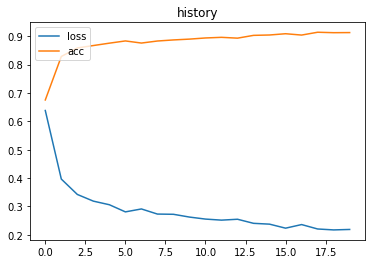

In [26]:
plt.plot(loss, label="loss")
plt.plot(accuracy, label="acc")
plt.legend(loc='upper left')
plt.title("history")
plt.show()

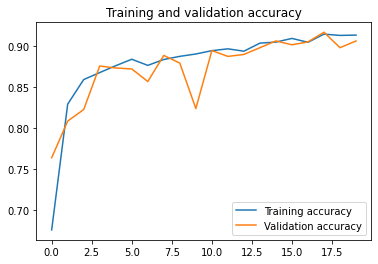

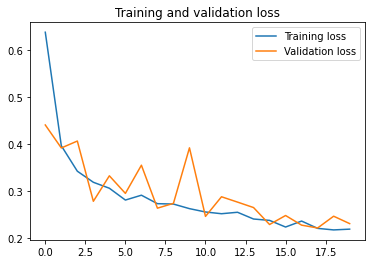

In [27]:
plt.plot(epochs, accuracy, label='Training accuracy')
plt.plot(epochs, val_accuracy, label='Validation accuracy')
plt.title('Training and validation accuracy')
plt.legend()
plt.figure()
plt.plot(epochs, loss, label='Training loss')
plt.plot(epochs, val_loss, label='Validation loss')
plt.title('Training and validation loss')
plt.legend()
plt.show()

Now, the training curve is better.

We can look at other informations.

In [28]:
predicted_classes = model.predict(x_test)
predicted_classes = np.round(predicted_classes)

In [29]:
correct = np.where(predicted_classes==y_test)[0]
incorrect = np.where(predicted_classes!=y_test)[0]
total_len = len(correct)+len(incorrect)
print(f'Correct : {len(correct)} => {np.round(len(correct) / total_len*100)} %')
print(f'Incorrect : {len(incorrect)} => {np.round(len(incorrect) / total_len*100)} %')


Correct : 3860 => 91.0 %
Incorrect : 382 => 9.0 %


Classification Report

In [30]:
target_names = ["Class {}".format(i) for i in range(2)]
print(classification_report(y_test, predicted_classes, target_names=target_names))

              precision    recall  f1-score   support

     Class 0       0.91      0.92      0.91      1102
     Class 1       0.91      0.90      0.91      1019

   micro avg       0.91      0.91      0.91      2121
   macro avg       0.91      0.91      0.91      2121
weighted avg       0.91      0.91      0.91      2121
 samples avg       0.91      0.91      0.91      2121

